In [ ]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import mne
import dill
import nilearn.plotting as nlplot
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from nilearn import surface
from scipy.io import loadmat
from scipy.signal import find_peaks
from torch import nn, optim
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm.auto import tqdm

from dataset import EEGDataset, MetadataType, RawEEGSpikesSingleton
from network.bunny import Bunny
from network.deepsif import DeepSIF
from network.lightbunny import LightBunny
from util import init_weights

sns.set_theme(style='whitegrid', palette='Set1')

In [2]:
instance = RawEEGSpikesSingleton()
instance.load(Path("source") / "nmm_spikes")

  0%|          | 0/994 [00:00<?, ?it/s]

In [3]:
n_electrodes = 64
seq_len = 500

fwd = mne.read_forward_solution(f'leadfield/{n_electrodes}_20k_fwd.fif')

with open(f'leadfield/{n_electrodes}_fwd_region.pkl', 'rb') as f:
    fwd_region = dill.load(f)

with open('source/metadata_train_240417.pkl', 'rb') as f:
    train_metadata: MetadataType = dill.load(f)

with open('source/metadata_val_240417.pkl', 'rb') as f:
    val_metadata: MetadataType = dill.load(f)

with open('source/metadata_test_240417.pkl', 'rb') as f:
    test_metadata: MetadataType = dill.load(f)

cortex = loadmat('anatomy/fs_cortex_20k.mat')
rm = loadmat('anatomy/fs_cortex_20k_region_mapping.mat')['rm']

Reading forward solution from /home/hareen/Projects/bunny/leadfield/64_20k_fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (20484 sources, 64 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


In [4]:
batch_size = 128
with_config = False


class Config:
    raw_channel_in = n_electrodes
    seq_len = seq_len
    pred_len = seq_len
    chunk_size = 25
    enc_in = 994
    dropout = 0.2
    d_model = 256
    seg_len = 25


def get_save_path(n: int, config: bool = False) -> Path:
    prefix = f"LightBunny_{n_electrodes}_240505"

    if config:
        return Path("models") / f"{prefix}_config.pkl"
    else:
        return Path("models") / f"{prefix}_epoch_{n}.pth"


config = Config()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LightBunny(config).apply(init_weights).to(device)
# model = Baseline(n_electrodes, 994).apply(init_weights).to(device)

summary(model, input_size=(batch_size, seq_len, n_electrodes))

Layer (type:depth-idx)                   Output Shape              Param #
LightBunny                               [128, 500, 994]           --
├─ResidualLinear: 1-1                    [128, 500, 256]           --
│    └─Linear: 2-1                       [128, 500, 64]            4,160
│    └─GELU: 2-2                         [128, 500, 64]            --
│    └─Linear: 2-3                       [128, 500, 64]            4,160
│    └─GELU: 2-4                         [128, 500, 64]            --
│    └─Linear: 2-5                       [128, 500, 64]            4,160
│    └─GELU: 2-6                         [128, 500, 64]            --
│    └─Linear: 2-7                       [128, 500, 256]           16,640
│    └─Linear: 2-8                       [128, 500, 256]           16,640
│    └─GELU: 2-9                         [128, 500, 256]           --
├─GRU: 1-2                               [128, 500, 994]           3,733,464
├─LightTS: 1-3                           [128, 500, 994]     

In [5]:
workers = 0

ds_train = EEGDataset(train_metadata, fwd_region)
ds_val = EEGDataset(val_metadata, fwd_region)
ds_test = EEGDataset(test_metadata, fwd_region)

loader_train = DataLoader(
    ds_train,
    batch_size=batch_size,
    num_workers=workers,
    collate_fn=EEGDataset.collate_fn,
    shuffle=True,
)
loader_val = DataLoader(
    ds_val,
    batch_size=batch_size,
    num_workers=workers,
    collate_fn=EEGDataset.collate_fn,
    shuffle=True,
)
loader_test = DataLoader(
    ds_test,
    batch_size=batch_size,
    num_workers=workers,
    collate_fn=EEGDataset.collate_fn,
    shuffle=True,
)

In [6]:
learning_rate = 0.0005

loss_fn = nn.MSELoss().to(device)
opt = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
epoch = 32

if with_config:
    config_path = get_save_path(epoch, config=True)
    with open(config_path, "wb") as f:
        dill.dump(config, f)

if epoch != 0:
    print(f"Continues from epoch {epoch}")
    model.load_state_dict(torch.load(get_save_path(epoch))["state_dict"])
    opt.load_state_dict(torch.load(get_save_path(epoch))["optimizer"])
else:
    print("Learning from scratch")

Continues from epoch 32


In [47]:
for _ in range(8):
    epoch += 1

    model.train()
    for data in tqdm(loader_train):
        eeg = data["eeg"].to(device)
        nmm = data["nmm"].to(device)

        opt.zero_grad()
        pred = model(eeg)
        cost = loss_fn(pred, nmm)
        cost.backward()
        opt.step()

    model.eval()
    with torch.no_grad():
        val_loss = 0

        for data in loader_val:
            eeg = data["eeg"].to(device)
            nmm = data["nmm"].to(device)

            pred = model(eeg)
            val_loss += loss_fn(pred, nmm)

        val_loss /= len(loader_val.dataset)

    torch.save(
        {
            "epoch": epoch,
            "val_loss": val_loss,
            "state_dict": model.state_dict(),
            "optimizer": opt.state_dict(),
        },
        get_save_path(epoch),
    )

    print(f"Epoch {epoch}: val_loss={val_loss}")

  0%|          | 0/1453 [00:00<?, ?it/s]

Epoch 9: val_loss=7.078887847455917e-06


  0%|          | 0/1453 [00:00<?, ?it/s]

Epoch 10: val_loss=7.126895525289001e-06


  0%|          | 0/1453 [00:00<?, ?it/s]

Epoch 11: val_loss=7.175874998210929e-06


  0%|          | 0/1453 [00:00<?, ?it/s]

Epoch 12: val_loss=7.210564945125952e-06


  0%|          | 0/1453 [00:00<?, ?it/s]

Epoch 13: val_loss=7.261749487952329e-06


  0%|          | 0/1453 [00:00<?, ?it/s]

Epoch 14: val_loss=7.3394435275986325e-06


  0%|          | 0/1453 [00:00<?, ?it/s]

Epoch 15: val_loss=7.401751190627692e-06


  0%|          | 0/1453 [00:00<?, ?it/s]

Epoch 16: val_loss=7.47010062696063e-06


In [111]:
for i in range(1, epoch + 1):
    print(f"Epoch {i}: val_loss={torch.load(get_save_path(i))['val_loss']}")

Epoch 1: val_loss=8.964359949459322e-06
Epoch 2: val_loss=7.178063697210746e-06
Epoch 3: val_loss=6.8518402258632705e-06
Epoch 4: val_loss=6.809397291362984e-06
Epoch 5: val_loss=6.551039405167103e-06
Epoch 6: val_loss=6.598562777071493e-06
Epoch 7: val_loss=6.224883236427559e-06
Epoch 8: val_loss=6.532012321258662e-06
Epoch 9: val_loss=6.959397978789639e-06
Epoch 10: val_loss=6.122978902567411e-06
Epoch 11: val_loss=6.176665010571014e-06
Epoch 12: val_loss=5.954191692580935e-06
Epoch 13: val_loss=5.851834430359304e-06
Epoch 14: val_loss=5.793179752799915e-06
Epoch 15: val_loss=5.78142953600036e-06
Epoch 16: val_loss=5.766523827333003e-06
Epoch 17: val_loss=5.763770332123386e-06
Epoch 18: val_loss=5.7684615057951305e-06
Epoch 19: val_loss=5.781423624284798e-06
Epoch 20: val_loss=5.657415840687463e-06
Epoch 21: val_loss=5.830196641909424e-06
Epoch 22: val_loss=5.843246071890462e-06
Epoch 23: val_loss=5.61601609661011e-06
Epoch 24: val_loss=5.60950093131396e-06
Epoch 25: val_loss=5.93840

In [8]:
with torch.no_grad():
    pccs = []

    for data in tqdm(loader_test):
        eeg = data["eeg"].to(device)
        nmm = data["nmm"].numpy()

        pred = model(eeg).cpu().numpy()

        for i in range(eeg.shape[0]):
            for lb in data['label'][i]:
                pr_r = pred[i][:, lb]
                tr_r = nmm[i][:, lb]
                pccs.append(np.corrcoef(pr_r, tr_r)[0, 1])

  0%|          | 0/91 [00:00<?, ?it/s]

In [9]:
pd.Series(pccs).describe()

count    23232.000000
mean         0.984636
std          0.033384
min          0.118855
25%          0.984626
50%          0.994784
75%          0.998520
max          0.999999
dtype: float64

In [8]:
idx = 5344

model.eval()
with torch.no_grad():
    pred = model(ds_test[idx]['eeg'].to(device).unsqueeze(0)).cpu().numpy()[0]
    truth = ds_test[idx]['nmm'].cpu().numpy()

ds_test[idx]['label']

[array([456, 435, 436, 452, 453, 457, 458, 432, 433, 434, 454, 455, 460,
        958, 459], dtype=uint16),
 array([766, 757, 765, 767, 771, 787, 790, 753, 754, 756, 758, 759, 770,
        772, 791, 792], dtype=uint16)]

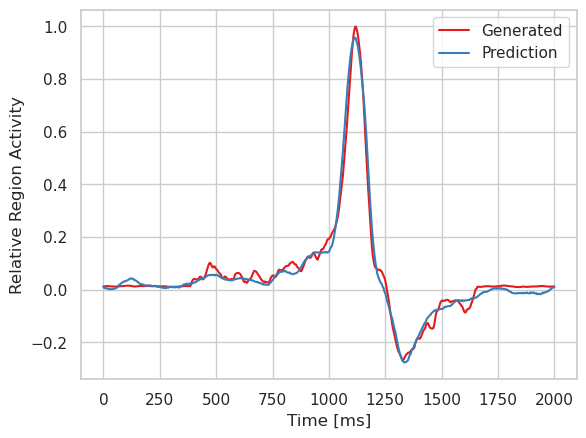

In [20]:
%matplotlib inline

region_id = 456

sns.lineplot(y=truth[:, region_id], x=np.linspace(0, 2000, 500), label='Generated')
sns.lineplot(y=pred[:, region_id], x=np.linspace(0, 2000, 500), label='Prediction')
plt.legend()
plt.xlabel('Time [ms]')
plt.ylabel('Relative Region Activity')
# plt.title('Generated/Predicted EEG at source region')
plt.show()

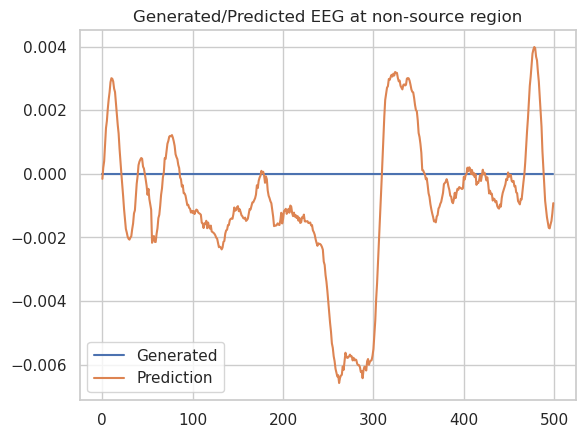

In [13]:
%matplotlib inline

region_id = 365

sns.lineplot(truth[:, region_id], label='Generated')
sns.lineplot(pred[:, region_id], label='Prediction')
plt.legend()

plt.title('Generated/Predicted EEG at non-source region')
plt.show()

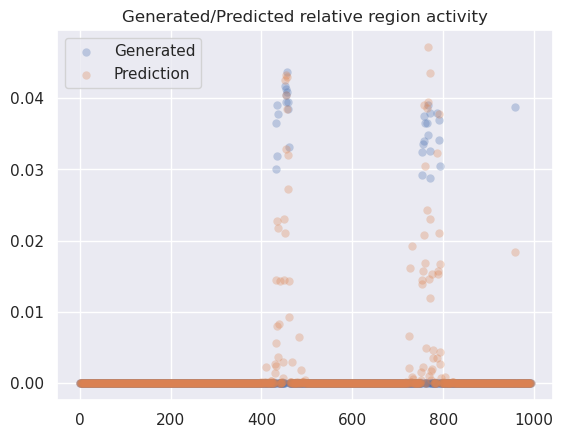

In [191]:
%matplotlib inline

sns.scatterplot((truth**2).mean(axis=0), label="Generated", alpha=0.3, linewidth=0)
sns.scatterplot((pred**2).mean(axis=0), label="Prediction", alpha=0.3, linewidth=0)
plt.legend()
plt.title("Generated/Predicted relative region activity")
plt.show()

In [23]:
model.eval()
with torch.no_grad():
    predictions = []
    sample = dill.load(open("source/eeg/64_oddball_sample.pkl", "rb"))
    for i in tqdm(range(0, (sample.shape[1] // seq_len) * seq_len, seq_len)):
        x = torch.FloatTensor(sample.T[i : i + seq_len]).to(device).unsqueeze(0)
        pred = model(x).cpu().numpy()[0]
        predictions.append(pred)
pred = np.concatenate(predictions)

  0%|          | 0/1 [00:00<?, ?it/s]

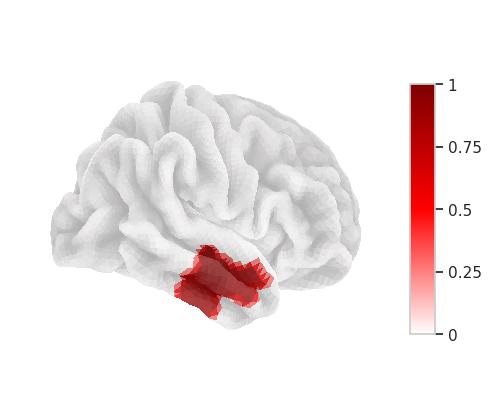

In [22]:
%matplotlib inline

hemi = 'right'
# act = (pred ** 2).mean(axis=0)
act = (truth ** 2).mean(axis=0)

surf_mesh = surface.load_surf_mesh(f'anatomy/fsaverage5/surf/{hemi[0]}h.pial')
surf_data = surface.load_surf_data(f'anatomy/fsaverage5/surf/{hemi[0]}h.curv')
hemi_ind = cortex[f'{hemi}_ind'].flatten() - 1

act /= np.max(act)
act_mapped = act[rm][:, hemi_ind].flatten()
# act_mapped /= np.max(act_mapped)

nlplot.plot_surf(
    surf_mesh=surf_mesh,
    surf_map=act_mapped,
    bg_map=surf_data,
    hemi=hemi,
    colorbar=True,
    bg_on_data=True,
    cmap='seismic',
    vmin=-1,
    vmax=1,
    cbar_vmin=0,
    darkness=1.3,
)

plt.show()

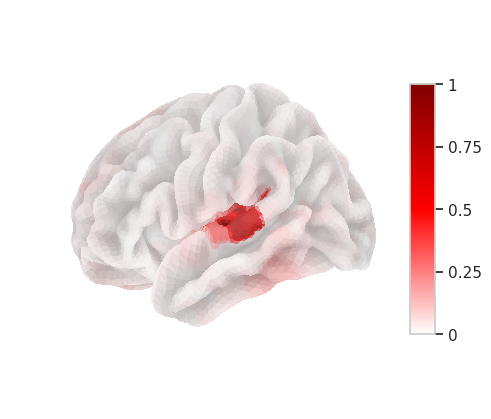

In [25]:
%matplotlib inline

hemi = 'left'
act = (pred ** 2).mean(axis=0)

surf_mesh = surface.load_surf_mesh(f'anatomy/fsaverage5/surf/{hemi[0]}h.pial')
surf_data = surface.load_surf_data(f'anatomy/fsaverage5/surf/{hemi[0]}h.curv')
hemi_ind = cortex[f'{hemi}_ind'].flatten() - 1

act /= np.max(act)
act_mapped = act[rm][:, hemi_ind].flatten()
# act_mapped /= np.max(act_mapped)

nlplot.plot_surf(
    surf_mesh=surf_mesh,
    surf_map=act_mapped,
    bg_map=surf_data,
    hemi=hemi,
    colorbar=True,
    bg_on_data=True,
    cmap='seismic',
    vmin=-1,
    vmax=1,
    cbar_vmin=0,
    darkness=1.3,
)

plt.show()